<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/bert-len64_merge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
!pip install transformers --quiet
!pip install wget --quiet

# Create Dataset

In [71]:
import torch
from torch.utils.data import Dataset
class ToxicDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len=512):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    target = self.targets[idx]

# Returns a dictionary containing the encoded sequence or sequence pair
# and additional information: the mask for sequence classification 
# and the overflowing elements if a max_length is specified.
    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

# Print metrics

In [72]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [73]:
from IPython.display import display
import pandas as pd

def print_stistics(training_stats,head=5):
        # Display floats with two decimal places.
        pd.set_option('display.precision', 2)

        # Create a DataFrame from our training statistics.
        df_stats = pd.DataFrame(data=training_stats)

        # Use the 'epoch' as the row index.
        df_stats = df_stats.set_index('epoch')

        # A hack to force the column headers to wrap.
        #df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

        # Display the table.
        display(df_stats)

**Метрики**
precision, recall, accuracy, f1



In [74]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report
def print_metrics(labels, predictions):
    
  print("Accuracy: {0:.2f} %".format(100 * accuracy_score(labels, predictions)))
  print("Recall: {0:.2f} %".format(100 * recall_score(labels, predictions)))
  print("Precision: {0:.2f} %".format(100 * precision_score(labels, predictions)))
  print("F1-score: {0:.2f} % \n".format(100 * f1_score(labels, predictions))) 
  print(classification_report(labels, predictions,digits=4))

**Матрица ошибок**

In [120]:
# from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_cm(labels, predictions, p=0.5):
  predictions = np.where(predictions <p,0,1)
  print(type(labels)) 
  print(type(predictions))   
  cm = confusion_matrix(labels, predictions)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Матрица ошибок')
  plt.ylabel('Актуальное значение')
  plt.xlabel('Прогнозируемое значение')
#   print("Accuracy: {0:.2f} %".format(100 * accuracy_score(labels, predictions)))
#   print("Recall: {0:.2f} %".format(100 * recall_score(labels, predictions)))
#   print("Precision: {0:.2f} %".format(100 * precision_score(labels, predictions)))
#   print("F1-score: {0:.2f} % \n".format(100 * f1_score(labels, predictions))) 
  print_metrics(labels, predictions)
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  plt.show()

**ROC - кривая**

In [119]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
import math


def plot_roc(y_test,predictions_test):
#   print('рассчитываем ROC AUC')
#   print(predictions_test)
#   print("y_test")
#   print(y_test)
  # рассчитываем ROC AUC
  lr_auc = roc_auc_score(y_test, predictions_test)
  print(': ROC AUC=%.3f' % (lr_auc))
  # рассчитываем roc-кривую
  fpr, tpr, treshold = roc_curve(y_test, predictions_test)
  t = pd.DataFrame({'fpr':fpr, 'tpr':tpr,'thr':treshold})
  # t.plot(x='fpr',y='tpr',grid=True,figsize=(7,7),xlim=(0,1.1),ylim=(0,1.1),kind='scatter')
  print(t.head())
  t['tpr - fpr'] = t['tpr'] - t['fpr']
  t['tpr - fpr'].apply(lambda x: '%.2f' % x)
  t['thr'].apply(lambda x: '%.2f' % x)
  t.sort_values('tpr - fpr',ascending=False)
  print(t.head())
  fig, ax = plt.subplots(figsize=(7,7))
  ax.scatter(t['fpr'], t['tpr'])
  for i, txt in enumerate(t['thr']):
    ax.annotate(round(txt,2), (t['fpr'][i], t['tpr'][i]))
  plt.show()

  roc_auc = auc(fpr, tpr)
  # строим график

  # размеры шрифта
  SMALL_SIZE = 10
  MEDIUM_SIZE = 14
  BIGGER_SIZE = 16
  plt.rcParams["figure.figsize"] = (7,7)
  plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
  plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
  plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
  plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
  plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
  plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
  plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
  plt.plot(fpr, tpr, color='darkorange',
          label='ROC кривая (area = %0.3f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC-кривая')
  plt.legend(loc="lower right",)
  plt.show()
  precision, recall, thresholds = precision_recall_curve(y_test, predictions_test)
  numerator = 2 * recall * precision
  denom = recall + precision
  f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
  max_f1 = np.max(f1_scores)
  max_f1_thresh = thresholds[np.argmax(f1_scores)]
  print('Best F1-Score: ',max_f1)
  print('Best threshold: ',max_f1_thresh)
  plot_cm(y_test,predictions_test, p=max_f1_thresh)
  # tt = pd.DataFrame({'pr':precision, 'recall':recall})
  # tt['pr - recall'] = abs(tt['pr'] - tt['recall'])
  # tt['pr - recall'].apply(lambda x: '%.2f' % x)
  # tt.sort_values('pr - recall',ascending=False)
  # print(tt.head())
  #create precision recall curve
  fig, ax = plt.subplots()
  ax.plot(recall, precision, color='purple')

  #add axis labels to plot
  ax.set_title('Precision-Recall Curve')
  ax.set_ylabel('Precision')
  ax.set_xlabel('Recall')

  #display plot
  plt.show() 

In [77]:
import matplotlib.pyplot as plt

import seaborn as sns

def plot_train(training_stats):
        # Use plot styling from seaborn.
        sns.set(style='darkgrid')

        # Increase the plot size and font size.
        sns.set(font_scale=1.5)
        plt.rcParams["figure.figsize"] = (12,6)

        df_stats = pd.DataFrame(data=training_stats)

        # Use the 'epoch' as the row index.
        df_stats = df_stats.set_index('epoch')

        # Plot the learning curve.
        plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
        plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

        # Label the plot.
        plt.title("Training & Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.xticks([1, 2, 3, 4,5])

        plt.show()

# Bert fine-tune

In [78]:
from tqdm import tqdm
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F

class BertClassifier:

    def __init__(self, model_path, tokenizer_path, n_classes=2, epochs=5, model_save_path='./trainer',max_len=64):
            self.model = BertForSequenceClassification.from_pretrained(model_path)
            self.tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            self.model_save_path=model_save_path
            self.max_len = max_len
            self.epochs = epochs
            self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
            self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
            self.model.to(self.device)

    def preparation(self, X_train, y_train, X_valid, y_valid,X_test,y_test,batch_size = 32):
        
        # Create the DataLoader for Training set
        self.train_set = ToxicDataset(X_train, y_train, self.tokenizer,max_len=self.max_len)
        self.train_loader = DataLoader(self.train_set, batch_size=batch_size, shuffle=True)

        # Create the DataLoader for Val set
        self.valid_set = ToxicDataset(X_valid, y_valid, self.tokenizer,max_len=self.max_len)
        self.valid_loader = DataLoader(self.valid_set, batch_size= batch_size, shuffle=True)

        # Create the DataLoader for Test set
        self.test_set = ToxicDataset(X_test, y_test, self.tokenizer,max_len=self.max_len)
        self.test_loader = DataLoader(self.test_set, batch_size= batch_size, shuffle=True)

        # helpers initialization
        self.optimizer = AdamW(self.model.parameters(), lr=2e-5, correct_bias=False)
        
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=500,
                num_training_steps=len(self.train_loader) * self.epochs
            )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)
    
    def fit(self):

        t0 = time.time()

        self.model = self.model.train()
        losses = []
        correct_predictions = 0

        for data in tqdm(self.train_loader):
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)
        print("")
        print("  Average training loss: {0:.2f}".format(train_loss))
        print("  Acc training: {0:.2f}".format(train_acc))
        print("  Training epcoh took: {:}".format(training_time))

        return train_acc, train_loss

    def eval(self):
        
        self.model = self.model.eval()
        losses = []
        correct_predictions = 0
        all_logits = []
        all_targets = []
        with torch.no_grad():
            for batch in self.valid_loader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                targets = batch["targets"].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                    )
                
                all_logits.append(outputs.logits)
                all_targets.append(targets)

                preds = torch.argmax(outputs.logits, dim=1)
                loss = self.loss_fn(outputs.logits, targets)
                correct_predictions += torch.sum(preds == targets)
                losses.append(loss.item())
        # print('all_targets')
        # print(all_targets)
        # print('all_logits')
        # print(all_logits)
        all_targets= torch.cat(all_targets, dim=0).cpu().numpy()
        all_logits = torch.cat(all_logits, dim=0)
        # print('torch.cat(all_logits, dim=0)')
        # print(all_logits)
        probs = torch.argmax(all_logits, dim=1).cpu().numpy()
        # print(probs)
        # print('probs')
        print()
        print('VALID:')
        print()
        print_metrics(all_targets, probs)
        
        val_acc = correct_predictions.double() / len(self.valid_set)
        val_loss = np.mean(losses)
        return val_acc, val_loss

    def train(self):
        training_stats = []
        best_accuracy = 0

        for epoch in range(self.epochs):
            print(f'Epoch {epoch + 1}/{self.epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')

            val_acc, val_loss = self.eval()
            print(f'Val loss {val_loss} accuracy {val_acc}')
            print('-' * 10)

            if val_acc > best_accuracy:
                torch.save(self.model, self.model_save_path)
                best_accuracy = val_acc

            ##### save statistics

            training_stats.append(
                {
                    'epoch': (epoch+ 1)*1,
                    'Training Loss': train_loss*1.0,
                    'Valid. Loss': val_loss*1.0,
                    'Training Accur': train_acc.item(),
                    'Valid. Accur.': val_acc.item(),
                }
            )

        print_stistics(training_stats)
        plot_train(training_stats)
        self.model = torch.load(self.model_save_path)
    
    def test(self):
        self.model = self.model.eval()
        losses = []
        correct_predictions = 0
        all_logits = []
        all_targets = []
        with torch.no_grad():
            for batch in self.test_loader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                targets = batch["targets"].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                    )
                
                # _debug(outputs) # debug print 

                all_logits.append(outputs.logits)
                all_targets.append(targets)

                preds = torch.argmax(outputs.logits, dim=1)
                loss = self.loss_fn(outputs.logits, targets)
                correct_predictions += torch.sum(preds == targets)
                losses.append(loss.item())
        # print('all_logits')
        # print(all_logits)
        all_logits = torch.cat(all_logits, dim=0)
        all_targets = torch.cat(all_targets, dim=0).cpu().numpy()
        # print('После torch.cat(all_logits, dim=0)')
        # print(all_logits)
        probs = F.softmax(all_logits, dim=1).cpu().numpy()
        # print('probs')
        # print(probs)
        print('TEST:')
        print()
        threshold=0.5
        
        plot_cm(all_targets, probs[:, 1])
        plot_roc(all_targets, probs[:, 1])
        
        val_acc = correct_predictions.double() / len(self.test_set)
        val_loss = np.mean(losses)
        return val_acc, val_loss


    def predict(self, text):
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }
        
        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)
        
        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction


УДАЛИТЬ -> отладка

In [79]:
def _debug(outputs):
    print('outputs')
    print(outputs)
    print()
    print('outputs.logits')
    print(outputs.logits)
    print()
    print('torch.argmax(outputs.logits, dim=1).cpu().numpy()')
    print(torch.argmax(outputs.logits, dim=1).cpu().numpy())
    print()
    print('torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]')
    print(torch.argmax(outputs.logits, dim=1).cpu().numpy()[0])
    ii=100
    print('F.softmax(outputs.logits, dim=1).cpu().numpy()')
    print(F.softmax(outputs.logits, dim=1).cpu().numpy())
    print()
    print('label=1,F.softmax(outputs.logits, dim=1).cpu().numpy()[0][1]')
    print(F.softmax(outputs.logits, dim=1).cpu().numpy()[0][1])
    print()
    print('F.sigmoid(outputs.logits).cpu().numpy()')
    print(F.sigmoid(outputs.logits).cpu().numpy())
    print()
    print('np.max(F.softmax(outputs.logits, dim=1).cpu().numpy()[0])')
    print(np.max(F.softmax(outputs.logits, dim=1).cpu().numpy()[0]))
    # raise ValueError("Real error")
    print('prediction')

# Train, Eval, Test

**Load dataset**

In [80]:
import wget
import os
# PATH_CLEANED_DATASET='data_original_RU_2ch.csv'
PATH_CLEANED_DATASET='data_original_RU_merge_2ch_and_ok.csv'

url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/'+PATH_CLEANED_DATASET


if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

**Split dataset**

In [81]:
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
sentences = df.comment.values
labels = df.toxic.values
print(len(sentences))
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.2, random_state=42)   # .15  .2
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=42) # .1764705882352941   .25
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

262702
(210161,)
(26270,)
(26271,)


Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

Epoch 1/5


100%|██████████| 6568/6568 [04:27<00:00, 24.57it/s]



  Average training loss: 0.18
  Acc training: 0.93
  Training epcoh took: 0:04:27
Train loss 0.17745636240586277 accuracy 0.932256698435961

VALID:

Accuracy: 95.58 %
Recall: 86.14 %
Precision: 90.02 %
F1-score: 88.04 % 

              precision    recall  f1-score   support

           0     0.9680    0.9778    0.9729     21306
           1     0.9002    0.8614    0.8804      4965

    accuracy                         0.9558     26271
   macro avg     0.9341    0.9196    0.9266     26271
weighted avg     0.9552    0.9558    0.9554     26271

Val loss 0.12257060837329578 accuracy 0.9557687183586464
----------
Epoch 2/5


100%|██████████| 6568/6568 [04:02<00:00, 27.13it/s]



  Average training loss: 0.11
  Acc training: 0.96
  Training epcoh took: 0:04:02
Train loss 0.11342292247838075 accuracy 0.9605826009583129

VALID:

Accuracy: 96.04 %
Recall: 89.08 %
Precision: 89.86 %
F1-score: 89.47 % 

              precision    recall  f1-score   support

           0     0.9746    0.9766    0.9756     21306
           1     0.8986    0.8908    0.8947      4965

    accuracy                         0.9604     26271
   macro avg     0.9366    0.9337    0.9352     26271
weighted avg     0.9603    0.9604    0.9603     26271

Val loss 0.11680556462235958 accuracy 0.9603745574968596
----------
Epoch 3/5


100%|██████████| 6568/6568 [04:04<00:00, 26.91it/s]



  Average training loss: 0.10
  Acc training: 0.97
  Training epcoh took: 0:04:04
Train loss 0.09694635776822608 accuracy 0.9670585884155481

VALID:

Accuracy: 96.43 %
Recall: 87.94 %
Precision: 92.79 %
F1-score: 90.30 % 

              precision    recall  f1-score   support

           0     0.9722    0.9841    0.9781     21306
           1     0.9279    0.8794    0.9030      4965

    accuracy                         0.9643     26271
   macro avg     0.9501    0.9317    0.9406     26271
weighted avg     0.9639    0.9643    0.9639     26271

Val loss 0.11090859753177836 accuracy 0.9642952304822808
----------
Epoch 4/5


100%|██████████| 6568/6568 [04:05<00:00, 26.74it/s]



  Average training loss: 0.09
  Acc training: 0.97
  Training epcoh took: 0:04:06
Train loss 0.08737241460931948 accuracy 0.9706891383272824

VALID:

Accuracy: 96.49 %
Recall: 89.22 %
Precision: 91.97 %
F1-score: 90.57 % 

              precision    recall  f1-score   support

           0     0.9751    0.9818    0.9784     21306
           1     0.9197    0.8922    0.9057      4965

    accuracy                         0.9649     26271
   macro avg     0.9474    0.9370    0.9421     26271
weighted avg     0.9646    0.9649    0.9647     26271

Val loss 0.10775847541708294 accuracy 0.9649042670625404
----------
Epoch 5/5


100%|██████████| 6568/6568 [04:07<00:00, 26.59it/s]



  Average training loss: 0.08
  Acc training: 0.97
  Training epcoh took: 0:04:07
Train loss 0.08106036878936929 accuracy 0.9733061795480609

VALID:

Accuracy: 96.48 %
Recall: 90.05 %
Precision: 91.23 %
F1-score: 90.63 % 

              precision    recall  f1-score   support

           0     0.9769    0.9798    0.9783     21306
           1     0.9123    0.9005    0.9063      4965

    accuracy                         0.9648     26271
   macro avg     0.9446    0.9402    0.9423     26271
weighted avg     0.9647    0.9648    0.9647     26271

Val loss 0.11189126544836206 accuracy 0.964828137490008
----------


,Training Loss,Valid. Loss,Training Accur,Valid. Accur.
epoch,,,,
1,0.18,0.12,0.93,0.96
2,0.11,0.12,0.96,0.96
3,0.10,0.11,0.97,0.96
4,0.09,0.11,0.97,0.96
5,0.08,0.11,0.97,0.96


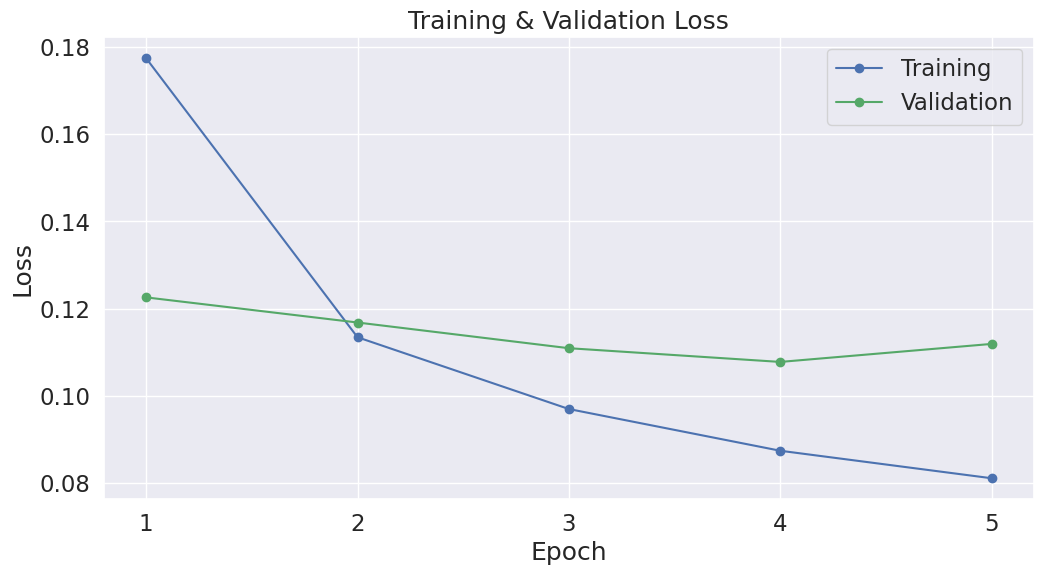

In [82]:
MODEL_PATH = 'cointegrated/rubert-tiny'

classifier = BertClassifier(
        model_path=MODEL_PATH,
        tokenizer_path=MODEL_PATH,
        max_len=64,
        n_classes=2,
        epochs=5,
        model_save_path='./trainer'
)

classifier.preparation(
        X_train=X_train,
        y_train=y_train,
        X_valid=  X_val,
        y_valid=  y_val,
        X_test=  X_test,
        y_test=  y_test,
        batch_size=32
    )

classifier.train()

# Test

TEST:

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Accuracy: 96.73 %
Recall: 91.06 %
Precision: 91.87 %
F1-score: 91.46 % 

              precision    recall  f1-score   support

           0     0.9787    0.9808    0.9798     21216
           1     0.9187    0.9106    0.9146      5054

    accuracy                         0.9673     26270
   macro avg     0.9487    0.9457    0.9472     26270
weighted avg     0.9672    0.9673    0.9672     26270

True Negatives:  20809
False Positives:  407
False Negatives:  452
True Positives:  4602


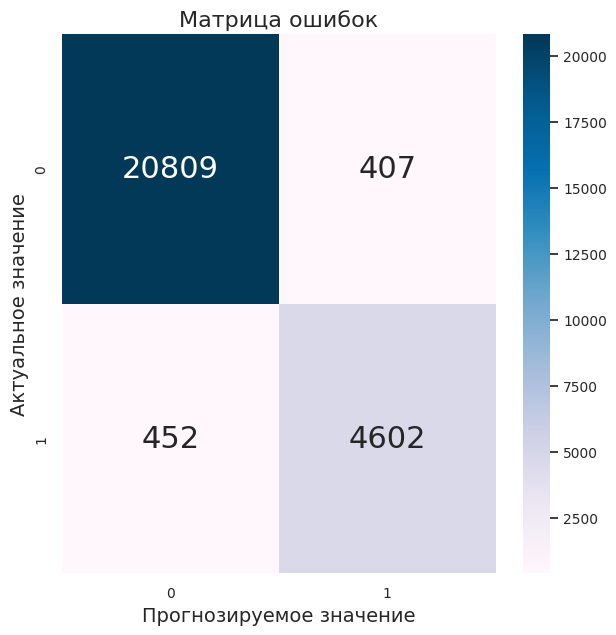

: ROC AUC=0.990
   fpr       tpr  thr
0  0.0  0.00e+00  2.0
1  0.0  1.98e-04  1.0
2  0.0  1.35e-02  1.0
3  0.0  1.39e-02  1.0
4  0.0  2.37e-02  1.0
   fpr       tpr  thr  tpr - fpr
0  0.0  0.00e+00  2.0   0.00e+00
1  0.0  1.98e-04  1.0   1.98e-04
2  0.0  1.35e-02  1.0   1.35e-02
3  0.0  1.39e-02  1.0   1.39e-02
4  0.0  2.37e-02  1.0   2.37e-02


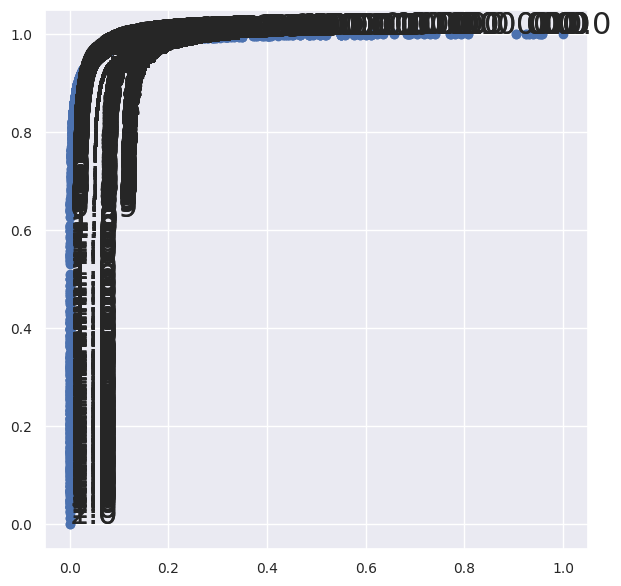

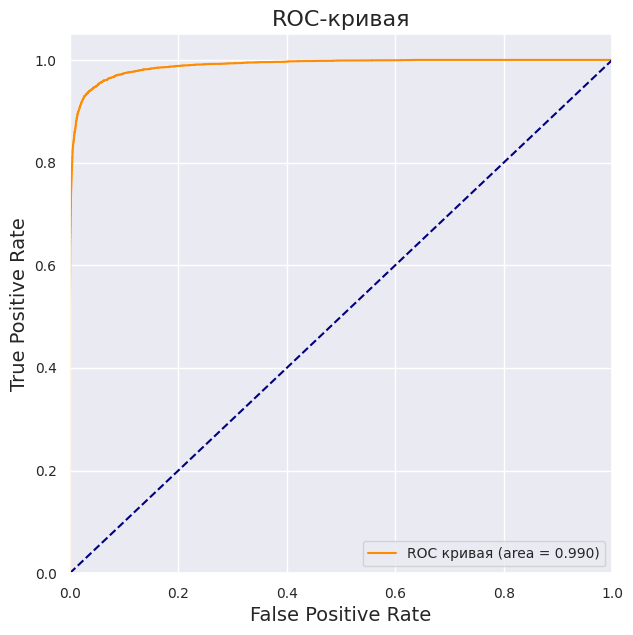

Best F1-Score:  0.9155798200384188
Best threshold:  0.6657672
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Accuracy: 96.82 %
Recall: 89.59 %
Precision: 93.61 %
F1-score: 91.56 % 

              precision    recall  f1-score   support

           0     0.9755    0.9854    0.9804     21216
           1     0.9361    0.8959    0.9156      5054

    accuracy                         0.9682     26270
   macro avg     0.9558    0.9407    0.9480     26270
weighted avg     0.9679    0.9682    0.9679     26270

True Negatives:  20907
False Positives:  309
False Negatives:  526
True Positives:  4528


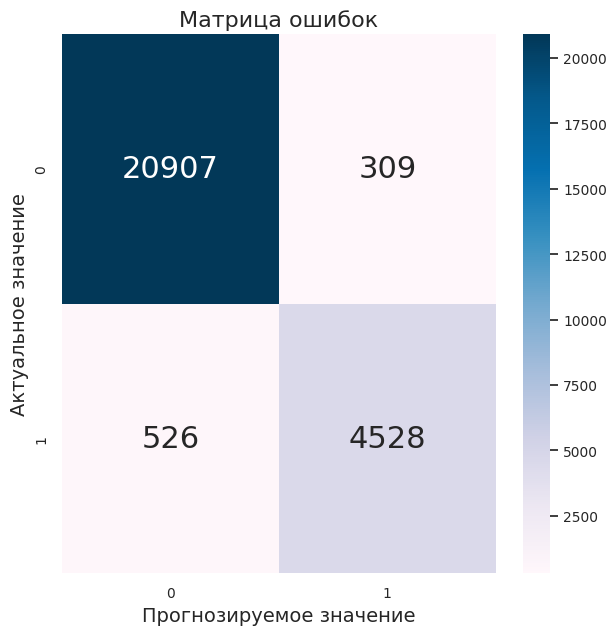

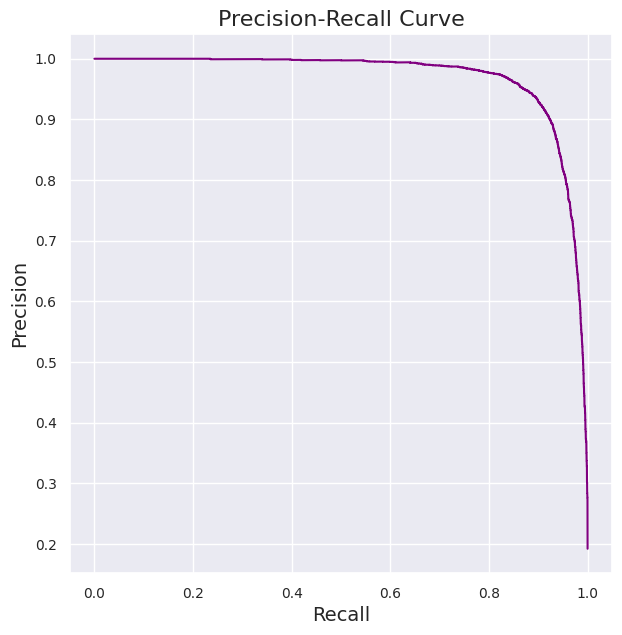

(tensor(0.9673, device='cuda:0', dtype=torch.float64), 0.10231454042679813)

In [121]:
classifier.test()

In [84]:
path = './trainer-for-transformers'
classifier.model.save_pretrained(path)
classifier.tokenizer.save_pretrained(path)

('./trainer-for-transformers/tokenizer_config.json',
 './trainer-for-transformers/special_tokens_map.json',
 './trainer-for-transformers/vocab.txt',
 './trainer-for-transformers/added_tokens.json')

In [85]:
AntiInterr=777+0